# Using Folium, DBSCAN, and Foursquare for spatial analysis

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Libraries](#libraries)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Whenever a stakeholder would like to do an investment and open a new venue (restaurant, hotel, etc ...) in a city,  he should know the competition he will be going against in that new region. It is very important to understand how is the status of the neighbourhoods and how they are viewed by the public in general; are they luxurious and satisfying the needs of the customers. 


So analyzing the venues in a city is very important to understand whether if a specific region is a hot spot and is a competitive one, and if different venue owners are working hard to satisfy the customers, maintain loyalty, and good fame, as a result becoming more successful in time.An initial comprehensive view of the market is important for new people who are planning to enter the market and open a new business. 

On the other hand, it is important to know if venue owners in specific regions are not caring that much thus about their businesses as a result becoming touristically undermined. One more question arises here, that what if there are venues who are so famous that they are not affected by their surrounding based on the type of service or commodities that they offer. This is also a point to be investigated for a new "business owner to be". Also if the new investor would open a new venue near another famous ones, he should expect a very strong challenge and a fierce competetion, at the same time our new venue investor would expect a lot of new intrigued customers whom their loyalty could be won.

So our goal is understanding undesrtanding how venues are rated and if there is a sort of a pattern or clustering within regions or neighbourhoods in terms of distance and quality of service.  As a result, the satkeholder gets a generic idea about the clusters of venues in the region it becomes easier to make a descion of where to start his new business. 

## Data <a name="data"></a>

It is clear that our project is a 3D dimensional spatial analysis/qualitative analysis. Hence based on definition of our problem, factors that will influence of the stakeholder are are:

* The rating of the venue
* The number of venues having close rated values and creating clusters
* Distance of venues to one another
* Outlier within a cluster
* The density of each cluster and how many venues exist in it


The following data sources will be needed to extract/generate the required information:
* Name of a specific city to search arround
* radius of search arround the city
* limit of number of avaialable venues in total 
* latitude, longitude, id of the venues using **Foursquare API** 
* The rating of each venue **Foursquare API** of the associated id of venue. Note that gathering the ratings is a premium data for this API in case one would require a lot of data. I have used a paid version to download the data and there is a csv file to be uplaoded.


## Libraries <a name="libraries"></a>

In this section, I will import all the required libraries which will be required for analysis

In [100]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import branca.colormap as cm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Methodology <a name="methodology"></a>

### Get coordinates of the city of interest
We will start my trying to find the location of New York using **geopy** 

In [4]:
def get_lat_long(address):
    """We pass an address and the function returns the lat and long."""
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)

    lat = location.latitude
    lon= location.longitude
    return lat,lon

lat_1,long_1=get_lat_long('New York, NY')
lat_1,long_1

(40.7127281, -74.0060152)

### Exploring and gathering the venues within the New york
Using Foursquare we will explore the region. At this point it is important to set the radius and the number of venues you want to limit your self to. Sometimes since the radius is small you might end up with fewer than the limit. The function below get latitude, longitude, limiting number of venues, and search radius, and return a dataframe of the venues found. Another function also is added which gets the category of each venue later to be used for visualization.

In [5]:
limit=200 #limit of venues
rad=1000 #radius of search 

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    """We pass an address and the function venue catagory."""

    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#function that gathers the venues
def explore_venue_df(latitude,longitude,LIMIT,radius):    
    #Foursquare info
    CLIENT_ID = 'XQ3QLGBS5Y3AXPLCS3AAG5D42N0C2MMOICTYDRGO0M3RWO0E' # your Foursquare ID
    CLIENT_SECRET = 'KHUVD2AXXLHF0UOA34RV2OJSSUNIHRAQKZRMLZMI1G53CXLT' # your Foursquare Secret
    VERSION = '20180604'
    
    #url to send get request 
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']

    dataframe = pd.json_normalize(items) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    
    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
    
    return dataframe_filtered


venues_df=explore_venue_df(lat_1,long_1,200,1000)


In [7]:
print("we have %s venues retrieved"%venues_df.shape[0])


we have 100 venues retrieved


In [110]:
#Lets visualize the name,category, venue id, and address
venues_df[['name','categories','id','address','distance']].sort_values(by='distance')

,name,categories,id,address,distance
4,City Hall Park,Park,3fd66200f964a520d8f11ee3,17 Park Row,69
11,Gibney Dance Center Downtown,Dance Studio,53373f26498e940581c90985,280 Broadway,136
2,Alba Dry Cleaner & Tailor,Laundry Service,4c606c3e1e5cd13ad1a1a1ed,140 Nassau St,145
0,The Bar Room at Temple Court,Hotel Bar,57f0689d498e7d49d9189369,123 Nassau St,157
1,"The Beekman, A Thompson Hotel",Hotel,56d8c0f8498edb854f926e6a,123 Nassau St,182
...,...,...,...,...,...
95,Jungsik,Korean Restaurant,4e67f1c7d16433b90090c8f3,2 Harrison St,712
99,Gotan,Café,5487845b498ed6d0cef81f32,130 Franklin St,724
96,Pasanella & Sons,Wine Shop,4b61d830f964a52088262ae3,115 South St,728
98,The Original Chinatown Ice Cream Factory,Ice Cream Shop,3fd66200f964a52033eb1ee3,65 Bayard St,733


### Gathering the ratings of each venue
Using Foursquare we will explore each venue and get its rating. At this point it is important to gather the values. Below you can see the function that takes the id of a venue previosly created and return the ratings. 

In [9]:
def get_venue_rating(venue_id_list):       
    #Foursquare info
    CLIENT_ID = 'LASR5Z0AWM0PVB0EB01CJLYQYNLCBSCI2IPXD5UHPBX1LWUN' # your Foursquare ID
    CLIENT_SECRET = 'GDD0NSZ4A05ZPNHBC0T41TS1ICORB4QGTZKL24PI5GUGJZLB' # your Foursquare Secret
    VERSION = '20180604'
    ratings_list=[]
    
    for venue_id in venue_id_list:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        results = requests.get(url).json()
        
        try:
            ratings_list.append(results['response']['venue']['rating'])
        except:
            ratings_list.append(np.nan)

    return ratings_list


In [11]:
venues_df['ratings']=get_venue_rating(venues_df.id)

### Note: not always free
Now that we gathered the ratings our data is ready for analysis. Since gathering venue rating is a special request and a limited quota exists for each user, I have gathered the ratings using my paid version. Try using your own client id and secret and see how it works.

In [12]:
venues_df[['name','ratings','lat','lng','categories']]

,name,ratings,lat,lng,categories
0,The Bar Room at Temple Court,9.3,40.711448,-74.006802,Hotel Bar
1,"The Beekman, A Thompson Hotel",9.1,40.711173,-74.006702,Hotel
2,Alba Dry Cleaner & Tailor,9.1,40.711434,-74.006272,Laundry Service
3,City Hall Park,8.9,40.712415,-74.006724,Park
4,The Wooly Daily,9.0,40.712137,-74.008395,Coffee Shop
...,...,...,...,...,...
95,Pasanella & Sons,NaN,40.707107,-74.001602,Wine Shop
96,SoulCycle TriBeCa,NaN,40.716178,-74.013007,Cycle Studio
97,Jungsik,NaN,40.718695,-74.009070,Korean Restaurant
98,Lyons Den Power Yoga,NaN,40.718872,-74.004989,Yoga Studio


In [14]:
venue_df_new=pd.read_csv("new_york.csv")
venue_df_new[['name','ratings','lat','lng','categories']]


,name,ratings,lat,lng,categories
0,The Bar Room at Temple Court,9.3,40.711448,-74.006802,Hotel Bar
1,"The Beekman, A Thompson Hotel",9.1,40.711172,-74.006702,Hotel
2,Alba Dry Cleaner & Tailor,9.1,40.711434,-74.006272,Laundry Service
3,The Wooly Daily,9.0,40.712137,-74.008395,Coffee Shop
4,City Hall Park,8.9,40.712415,-74.006724,Park
...,...,...,...,...,...
95,Jungsik,8.9,40.718695,-74.009070,Korean Restaurant
96,Pasanella & Sons,9.0,40.707107,-74.001602,Wine Shop
97,Lyons Den Power Yoga,8.7,40.718872,-74.004989,Yoga Studio
98,The Original Chinatown Ice Cream Factory,9.0,40.715521,-73.998145,Ice Cream Shop


You can see how the data is similar and complete

### Clustering using DBSCAN

To analyze each region, we will cluster the venues using the latitude, longitude, and rating. As a result one would realize how the venues are close to each other and how similar the ratings are. This will give us a strong idea about each region and how tough the competition is.

For applying our clustering, we will be using DBSCAN (density based spatial clustering with application of noise). As you can see from it's name it clusters groups with similar characteristics and closeness and shows the outlier who do not belong to the group. This will be a good indicator to see if there are special cases and venues which have randomly opened. Also the outlier even would be indicator for the influence of the venues.  

### Analysis

In [15]:
def dbscan_df(dataframe,features,epsilon=0.3,samples=5,vis=False):
    """We the features and a dataframe."""     
    df=dataframe.copy()
    df=df[features]

    X=np.array(df)
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=epsilon, min_samples=samples).fit(X)
    
    if vis:
        df.plot(kind='scatter',x='lng',y='lat',c='labels',cmap='jet')
        plt.show()

    return db.labels_   

The function above does 3 steps:
* Applies standardization to the data
* Applies clustering based on the 0.7 epsilon(distance) and minimum number of venue sample which is 4. The 4 was the most logical number is in an urban city you might have stores on you right, left, back and front. One can test with different values but I got satisfactory results for this values
* Based on the clustering return a class from 0 to N (labels). Note that a -1 is an outlier

In [16]:
venue_df_new['labels']=dbscan_df(venue_df_new,features=['lat','lng','ratings'],epsilon=0.7,samples=4)
venues_df=venue_df_new.copy()
venues_df[['name','ratings','lat','lng','categories','labels']]

,name,ratings,lat,lng,categories,labels
0,The Bar Room at Temple Court,9.3,40.711448,-74.006802,Hotel Bar,0
1,"The Beekman, A Thompson Hotel",9.1,40.711172,-74.006702,Hotel,0
2,Alba Dry Cleaner & Tailor,9.1,40.711434,-74.006272,Laundry Service,0
3,The Wooly Daily,9.0,40.712137,-74.008395,Coffee Shop,0
4,City Hall Park,8.9,40.712415,-74.006724,Park,0
...,...,...,...,...,...,...
95,Jungsik,8.9,40.718695,-74.009070,Korean Restaurant,1
96,Pasanella & Sons,9.0,40.707107,-74.001602,Wine Shop,-1
97,Lyons Den Power Yoga,8.7,40.718872,-74.004989,Yoga Studio,1
98,The Original Chinatown Ice Cream Factory,9.0,40.715521,-73.998145,Ice Cream Shop,-1


### Cluster performance

Let's apply some additional analysis to cluster performance. Let's count the clusters. This can give a better idea of how the data is centeralized. 

In [101]:
pd.DataFrame(venues_df.labels.value_counts())

,labels
1,35
2,21
-1,16
0,12
3,11
4,5


Let's add one more indicator to see how far each point is away from it's group value. We Normalize the data $Rating_{N_i} = \frac{Rating_i - Rating_{min}}{Rating_{max}-Rating_{min}}$. 



In [18]:
venues_df['norm']=(venues_df.ratings - venues_df.ratings.min())/(venues_df.ratings.max() - venues_df.ratings.min())

We also calculate the average of each group to have a general idea

In [23]:
means=venues_df.groupby('labels').mean()
mapper=dict(zip(means.index, means.ratings))
venues_df['avg_rate']=venues_df['labels'].replace(mapper)

venues_df[['labels','ratings','norm','avg_rate']]

,labels,ratings,norm,avg_rate
0,0,9.3,0.857143,9.108333
1,0,9.1,0.714286,9.108333
2,0,9.1,0.714286,9.108333
3,0,9.0,0.642857,9.108333
4,0,8.9,0.571429,9.108333
...,...,...,...,...
95,1,8.9,0.571429,8.682857
96,-1,9.0,0.642857,8.962500
97,1,8.7,0.428571,8.682857
98,-1,9.0,0.642857,8.962500


####  As you saw above the ratings are comparatively high and close to each other so normalization give a good idea of differences. Let's visualize the results in a histogram.

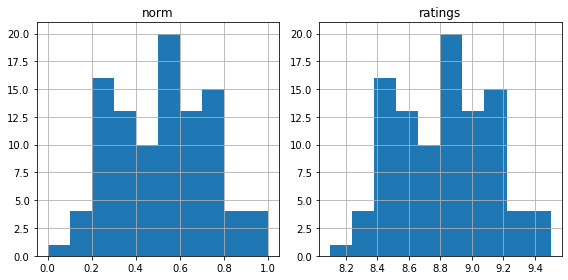

In [153]:
venues_df[['ratings','norm']].hist(figsize=(8,4))
plt.tight_layout()

### Visualize the cluster
Using Folium we will plot the data to have an idea of what is happening. The color code is as follows:
* Each color indicates a class since the values are very close 
* The sizes indicates the magnitude of ratings
* The outlier can be viewed as a darker color arround the clusters


In [103]:
# set color scheme for the clusters
colors_array = cm.jet(np.linspace(0, 1, len(venues_df.labels.unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#codes
colors_code={}
for index,value in enumerate(mapper.keys()):
    colors_code[value]= rainbow[index]


    

#create map
venues_map = folium.Map(location=[lat_1, long_1], zoom_start=15) # generate map centred around Ecco

for name,lat, lon,lbl,rating,norm,avg,cat in zip(venues_df['name'],venues_df['lat'], venues_df['lng'],venues_df['labels'],venues_df['ratings'],venues_df['norm'],venues_df['avg_rate'],venues_df['categories'],):
    if lbl==-1: title="outsider - rate: %0.3f - category: %s"%(rating,cat)
    else: title="region: %s - rate: %0.3f avg_rate: %0.3f - category: %s"%(lbl+1,rating,avg,cat) 
    
        
    
    
    label = folium.Popup(name+"->"+title, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=abs(norm*20),
        popup=label,
        color='black',
        fill=True,
        fill_color=colors_code[lbl],
        fill_opacity=1.0).add_to(venues_map)
    
    
    
       
# display map
venues_map.save(outfile= "test.html")
venues_map


##### To have an idea about which is the best region, we can plot the labels versus average rating of the clusters and visualize the categories of the top cluster

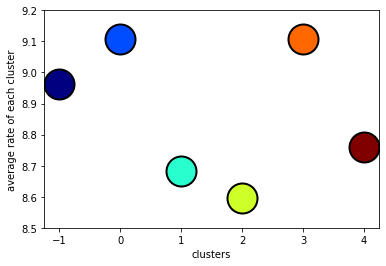

,categories
Memorial Site,3
Auditorium,1
Building,1
Electronics Store,1
Plaza,1
Park,1
Coffee Shop,1
Scenic Lookout,1
Gourmet Shop,1


In [118]:
#plotting of the rates
for i in mapper.keys():
    plt.plot(i,mapper[i],color=colors_code[i],markersize=30,marker='o',mec='black',mew=2)
plt.ylim((8.5,9.2))
plt.xlabel('clusters')
plt.ylabel('average rate of each cluster')
plt.show()

#categories of the best region
pd.DataFrame(venues_df[venues_df.avg_rate==venues_df.avg_rate.max()]['categories'].value_counts())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f125d467610>,
      dtype=object)

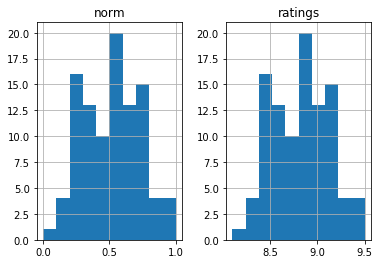

In [142]:
venues_df[["ratings",'norm']].hist()

### The largest cluster categories

In [186]:
#categories of the best region
maxer=venues_df.labels.value_counts().index[0]
pd.DataFrame(venues_df[venues_df.labels==maxer]['categories'].value_counts()).head()

,categories
Cocktail Bar,2
Gym / Fitness Center,2
Gym,2
French Restaurant,2
Café,2


## Results and Discussion <a name="results"></a>

In this project, we requested from the Foresquare API the venues and associated ratings of the city of New York within a radius of 1000 and limit of 200 venues. We recieved arround 100 venues. Since Foursquare has quota of 50 venues per day, externally the data was gathered using a paid version to ensure ratings for all the venues.

In our analysis,  we have clustered these venues based on their latitude,longitude, and rating using DBSCAN.  6 clusteres were created and one is an outliers cluster. We have realized a spatial and rating wise clustering does exist where the top ratings cluster being the city center towards and its west, the worst being the south but includes some far outliers with much higher ratings. The best clusters has venues which are shops, and memorial cites, etc ... making it a great touristic hub. The largest cluster was cluster 1 and located in the North, although it had a low average rating, and checking it's categories you can see it's mainly composed of restaurants and cafe's which are common daily venues. One clusters remians which is the Eastern part of New York where we can see that the density is low based on the venue gathering radius  and there is a gap for venues from the center to that region. to further understand that region one can analyze that section. One can extract the latitude and longitude and rerun the code. What we can also see that the outliers have larger ratings compared to their clusters, as a results being special and better than those regions which a new stakeholder should realize that these sorts of places have a specific shine to them and might monopolizing the market. For example the Washington market park where it is a public park and funded by the government which makes it a well groomed site. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to analyze different parts the city of New York with a specific vicinity or radius, in order to understand the quality of of each region and detect homogenous clusters and outlier based on the ratings. This aids stakeholders to make a final descions about opening a new venue. By clustering the venues using latitide, longitude, and rating from Foursquare data, we were able to detect the clusteres within each part of the city and calculate an average rating for each cluster, as a result giving the ability to stackholders to have a generic view of the city's quality of venues and supplying them with an insight regarding the quality,luxury, and expectation of customers for each region.    


Final decission on optimal venue location will be made by stakeholders based on specific characteristics of  taking into consideration the average rating and additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood, etc. Not to forget the amount of capital a stakeholder would be ready invest in the new venue.